# Example-34: Orbit (ORM)

In [1]:
# In this example orbit responce matrix is computed for ideal lattice
# Next, orbit distortion is introduced (quadrupole and sextupole transverse shifts)
# Orbit is corrected using ideal ORM (experiment to design correction)
# Next, additional gradient and skew error are introduced in quadrupoles
# With this, real ORM matrix will be off, but design ORM still can be used to correct orbit

In [2]:
# Import

from pprint import pprint

import torch

from pathlib import Path
from matplotlib import pyplot as plt

from twiss import twiss

from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import evaluate
from model.command.util import series

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.wrapper import group

from model.command.orbit import orbit
from model.command.orbit import parametric_orbit

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:float = parameters['nux'] % 1
nu_qy:float = parameters['nuy'] % 1

In [4]:
# Build and setup lattice

# Quadrupoles are splitted into 2**2 parts, Dipoles -- 2**4 part
# Correctors are inserted between parts

path = Path('ic.lte')
data = load_lattice(path)

ring:Line = build('RING', 'ELEGANT', data)
ring.propagate = True
ring.flatten()
ring.merge()

ring.split((None, ['BPM'], None, None))
ring.roll(1)

n_q = 2**2
n_d = 2**4

for name in [name for name, kind, *_ in ring.layout() if kind == 'Quadrupole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(n_q - 1))
    ring.split((n_q, None, [name], None), paste=[corrector]) 
    
for name in [name for name, kind, *_ in ring.layout() if kind == 'Dipole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(n_d - 1))
    ring.split((n_d, None, [name], None), paste=[corrector])

for element in ring:
    if element.__class__.__name__ == 'Dipole':
        element.linear = True
    
ring.splice()

In [5]:
# Compare linear tunes

state = torch.tensor(4*[0.0], dtype=torch.float64)
matrix = torch.func.jacrev(ring)(state)
(nuqx, nuqy), *_ = twiss(matrix)

print(nu_qx - nuqx)
print(nu_qy - nuqy)

tensor(1.4433e-15, dtype=torch.float64)
tensor(-9.9920e-16, dtype=torch.float64)


In [6]:
# Compute closed orbit

fp = 1.0E-3*torch.randn(4, dtype=torch.float64)
fp, *_ = orbit(ring, fp, [], alignment=False, limit=8, epsilon=1.0E-12)

# Chop small values

fp = [fp]
chop(fp)
fp, *_ = fp

print(fp)

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Compute parametric closed orbit (1st order derivatives wrt cx and cy at each monitor location)

n_kick = ring.describe['Corrector']

cx = torch.tensor(n_kick*[0.0], dtype=torch.float64)
cy = torch.tensor(n_kick*[0.0], dtype=torch.float64)

pox, *_ = parametric_orbit(ring,
                           fp,
                           [cx],
                           (1, 'cx', ['Corrector'], None, None),
                           alignment=False,
                           advance=True, 
                           full=False)


poy, *_ = parametric_orbit(ring,
                           fp,
                           [cy],
                           (1, 'cy', ['Corrector'], None, None),
                           alignment=False,
                           advance=True, 
                           full=False)

chop(pox)
chop(poy)

torch.Size([72])
torch.Size([32])
torch.Size([32, 72])


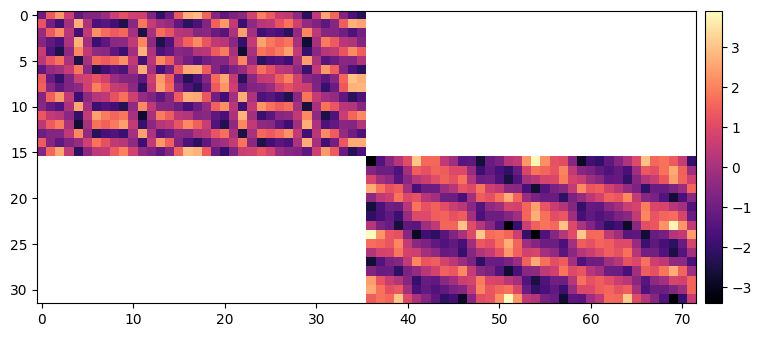

In [8]:
# Compute orbit responce matrix

# [qx_1, qx_2, ..., qx_n, qy_1, qy_2, ..., qy_n] = M @ [cx_1, cx_2, ..., cx_k, cy_1, cy_2, ..., cy_k]

# qx_i/qy_i -- qx/qy orbit at BPM i
# cx_i/cy_i -- cx/cy angle at corrector i

def qxqy(cxy, pox, poy):
    cx, cy = cxy.reshape(1 + 1, -1)
    qx, _, qy, _ = torch.stack([evaluate(tx, [fp, cx]) + evaluate(ty, [fp, cy]) for tx, ty in zip(pox, poy)]).T
    return torch.cat([qx, qy])

cx = torch.tensor(n_kick*[0.0], dtype=torch.float64)
cy = torch.tensor(n_kick*[0.0], dtype=torch.float64)

cxy = torch.cat([cx, cy])
orm = torch.func.jacrev(qxqy)(cxy, pox, poy)

print(cxy.shape)
print(qxqy(cxy, pox, poy).shape)
print(orm.shape)

data = orm.clone()
data[data==0.0] = torch.nan

plt.figure(figsize=(34/4, 72/4))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

tensor([-0.0003,  0.0004,  0.0007,  0.0013], dtype=torch.float64)
tensor([-0.0003,  0.0004,  0.0007,  0.0013], dtype=torch.float64)
True



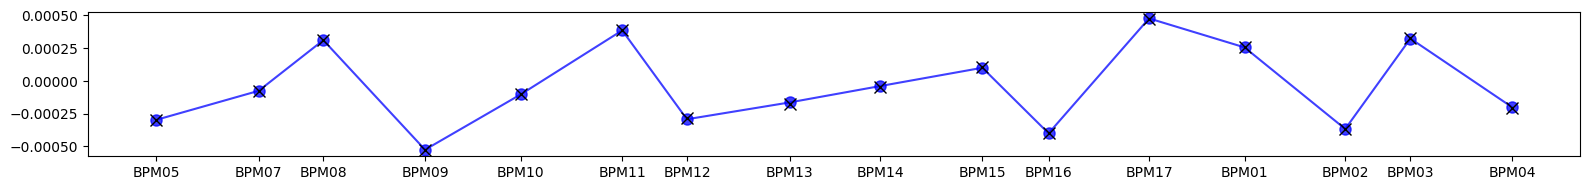

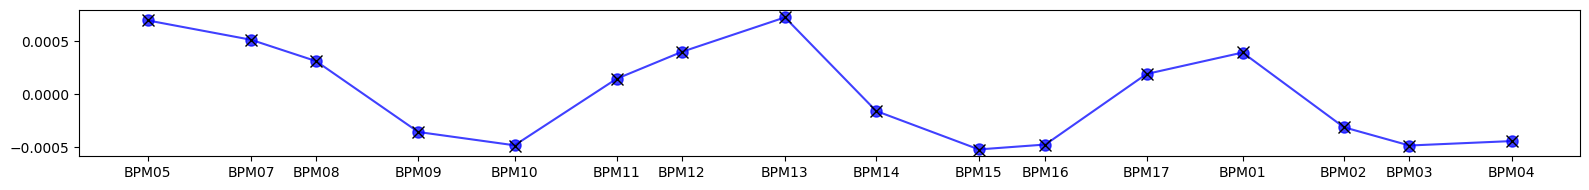

In [9]:
# Set corrector errors

cx = 50.0E-6*torch.randn_like(cx)
cy = 50.0E-6*torch.randn_like(cy)

# Find closed orbit with errors

points, *_ = orbit(ring, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=False, advance=True, full=False, limit=16, epsilon=1.0E-12)

# Set wrapper

start, *_, end = ring.names
mapping, *_ = group(ring, start, end, ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=False)

# Propagate estimated closed orbit

point, *_ = points
print(point)
print(mapping(point, cx, cy))
print(torch.allclose(point, mapping(point, cx, cy), rtol=1.0E-12, atol=1.0E-12))
print()

# Set orbit

qx, _, qy, _ = points.T

# Compute orbit from known errors

Qx, Qy = (orm @ torch.cat([cx, cy])).reshape(1 + 1, -1)

# qx vs Qx

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Qx.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# qy vs Qy

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), Qy.cpu().numpy(), fmt=' ', color='black', marker='x', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

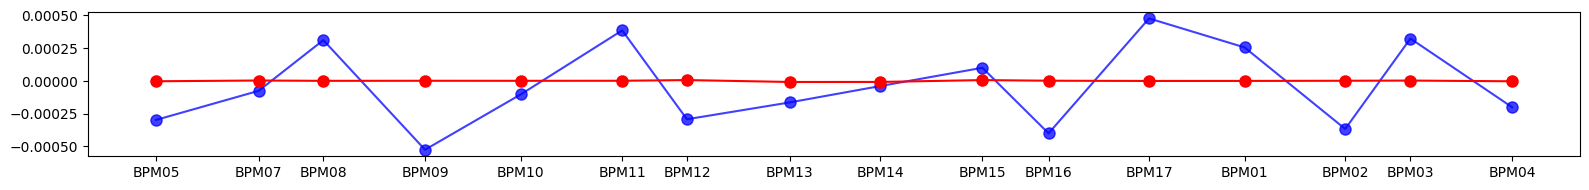

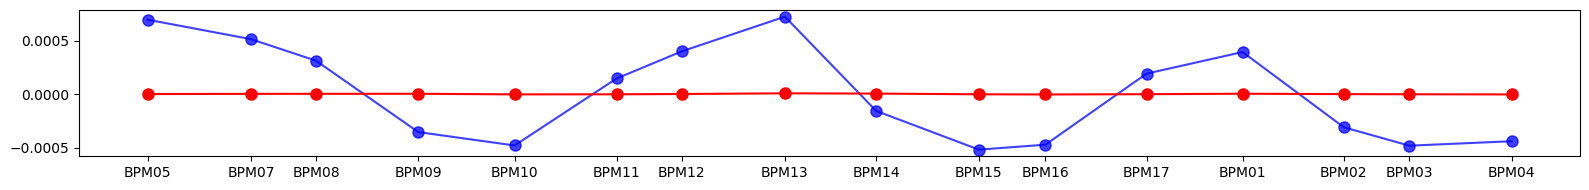

In [10]:
# Perform one correction step (use measured orbit and model matrix)

dcx, dcy = - (torch.linalg.pinv(orm) @ torch.cat([qx, qy])).reshape(1 + 1, -1)

# Find closed orbit with errors and add corrections

points, *_ = orbit(ring, fp, [cx + dcx, cy + dcy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=False, advance=True, full=False, limit=16, epsilon=1.0E-12)

# Set orbit

dqx, _, dqy, _ = points.T

# qx vs dqx

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), dqx.cpu().numpy(), fmt='-', color='red', marker='o', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# qy vs dqy

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), dqy.cpu().numpy(), fmt='-', color='red', marker='o', ms=8, alpha=1)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

In [11]:
# Correction lool (use measured orbit and model matrix)

# Given measured orbit values qx and qy (differences with reference orbit)
# New corrector settings are computed and applied
# Orbit is remeasured and procedure is repeated

cx = 50.0E-6*torch.randn_like(cx)
cy = 50.0E-6*torch.randn_like(cy)

for _ in range(16):
    points, *_ = orbit(ring, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=False, advance=True, full=False, limit=16, epsilon=1.0E-12)
    qx, _, qy, _ = points.T
    dcx, dcy = - 0.5*(torch.linalg.pinv(orm) @ torch.cat([qx, qy])).reshape(1 + 1, -1)
    cx += dcx
    cy += dcy
    print(torch.cat([qx, qy]).norm())

tensor(0.0019, dtype=torch.float64)
tensor(0.0009, dtype=torch.float64)
tensor(0.0005, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(5.6358e-05, dtype=torch.float64)
tensor(2.8163e-05, dtype=torch.float64)
tensor(1.4078e-05, dtype=torch.float64)
tensor(7.0379e-06, dtype=torch.float64)
tensor(3.5187e-06, dtype=torch.float64)
tensor(1.7593e-06, dtype=torch.float64)
tensor(8.7964e-07, dtype=torch.float64)
tensor(4.3982e-07, dtype=torch.float64)
tensor(2.1991e-07, dtype=torch.float64)
tensor(1.0996e-07, dtype=torch.float64)
tensor(5.4978e-08, dtype=torch.float64)


In [12]:
# In the above, errors were passed as deviaton variables
# Another option is to add errors to the main attributes

# Generate lattice with errors (errors are added to the main attributes)

error:Line = ring.clone()

cx = 50.0E-6*torch.randn_like(cx)
cy = 50.0E-6*torch.randn_like(cx)

index = 0
label = ''

for line in error.sequence:
    for element in line:
        if element.__class__.__name__ == 'Corrector':
            if label != element.name:
                index +=1
            label = element.name
            element.cx = cx[index - 1].item()
            element.cy = cy[index - 1].item()

# Perform correction

cx = torch.zeros_like(cx)
cy = torch.zeros_like(cx)

for _ in range(16):
    points, *_ = orbit(error, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=False, advance=True, full=False, limit=16, epsilon=1.0E-12)
    qx, _, qy, _ = points.T
    dcx, dcy = - 0.5*(torch.linalg.pinv(orm) @ torch.cat([qx, qy])).reshape(1 + 1, -1)
    cx += dcx
    cy += dcy
    print(torch.cat([qx, qy]).norm())

tensor(0.0013, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(7.8633e-05, dtype=torch.float64)
tensor(3.9300e-05, dtype=torch.float64)
tensor(1.9644e-05, dtype=torch.float64)
tensor(9.8195e-06, dtype=torch.float64)
tensor(4.9086e-06, dtype=torch.float64)
tensor(2.4538e-06, dtype=torch.float64)
tensor(1.2266e-06, dtype=torch.float64)
tensor(6.1319e-07, dtype=torch.float64)
tensor(3.0653e-07, dtype=torch.float64)
tensor(1.5324e-07, dtype=torch.float64)
tensor(7.6602e-08, dtype=torch.float64)
tensor(3.8294e-08, dtype=torch.float64)


tensor([ 0.0007, -0.0005, -0.0005, -0.0012], dtype=torch.float64)
tensor([ 0.0007, -0.0005, -0.0005, -0.0012], dtype=torch.float64)
True



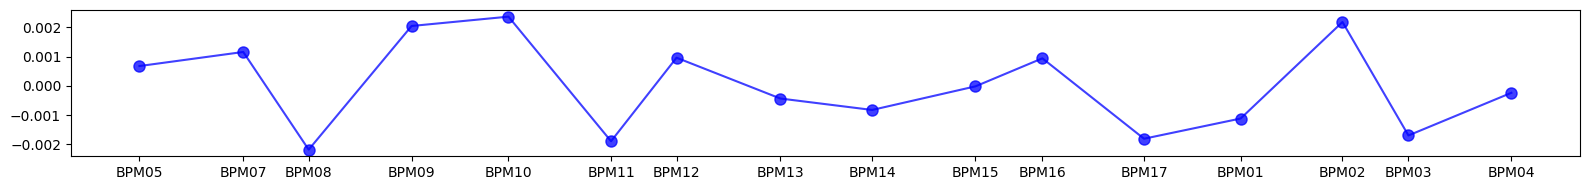

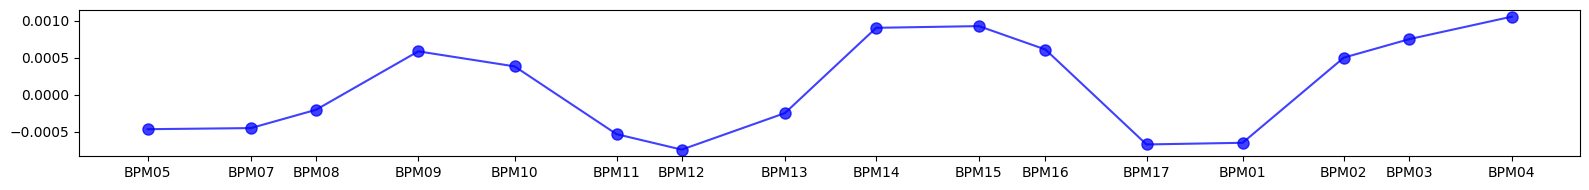

In [13]:
# Add alignment and focusing errors to quadrupoles

# Note, adding the same alignmet elemets to parts is not valid for all types of alignmet errors

error:Line = ring.clone()

n_quad = error.describe['Quadrupole']

dx = 100.0E-6*torch.randn(n_quad, dtype=torch.float64)
dy = 100.0E-6*torch.randn(n_quad, dtype=torch.float64)

kn = 0.1*torch.randn(n_quad, dtype=torch.float64)
ks = 0.1*torch.randn(n_quad, dtype=torch.float64)

index = 0
label = ''

for line in error.sequence:
    for element in line:
        if element.__class__.__name__ == 'Quadrupole':
            if label != element.name:
                index +=1
            label = element.name
            element.dx = dx[index - 1].item()
            element.dy = dy[index - 1].item()
            element.kn = (element.kn + kn[index - 1]).item()
            element.ks = (element.ks + ks[index - 1]).item()

# Compute closed orbit with zero corrector
# Note, alignment is on

cx = torch.zeros_like(cx)
cy = torch.zeros_like(cx)

points, *_ = orbit(error, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=True, advance=True, full=False, limit=16, epsilon=1.0E-12)

# Test closed orbit

point, *_ = points

print(point)
print(error(point, alignment=True))
print(torch.allclose(point, error(point, alignment=True), rtol=1.0E-12, atol=1.0E-12))
print()

# Plot orbit

qx_initial, _, qy_initial, _ = points.T

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx_initial.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy_initial.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

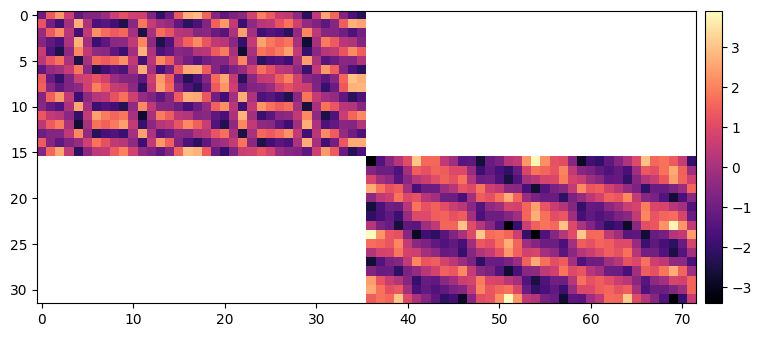

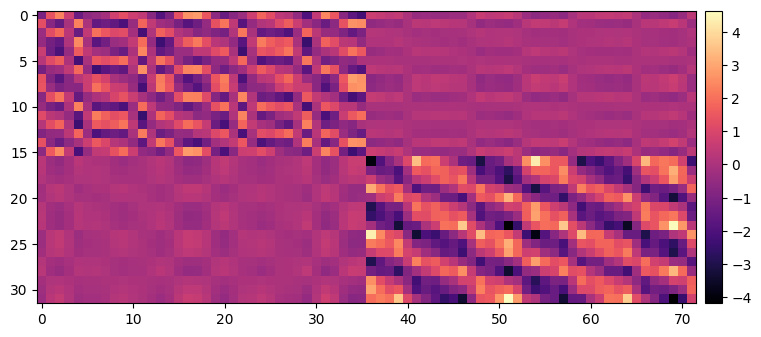

In [14]:
# Compure ORM for model with errors (measured ORM)

n_kick = ring.describe['Corrector']

cx = torch.tensor(n_kick*[0.0], dtype=torch.float64)
cy = torch.tensor(n_kick*[0.0], dtype=torch.float64)

pox, *_ = parametric_orbit(error,
                           fp,
                           [cx],
                           (1, 'cx', ['Corrector'], None, None),
                           alignment=False,
                           advance=True, 
                           full=False)


poy, *_ = parametric_orbit(error,
                           fp,
                           [cy],
                           (1, 'cy', ['Corrector'], None, None),
                           alignment=False,
                           advance=True, 
                           full=False)

chop(pox)
chop(poy)

cx = torch.tensor(n_kick*[0.0], dtype=torch.float64)
cy = torch.tensor(n_kick*[0.0], dtype=torch.float64)

cxy = torch.cat([cx, cy])
orm_error = torch.func.jacrev(qxqy)(cxy, pox, poy)

data = orm.clone()
data[data==0.0] = torch.nan
plt.figure(figsize=(34/4, 72/4))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

data = orm_error.clone()
data[data==0.0] = torch.nan
plt.figure(figsize=(34/4, 72/4))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

In [15]:
# Find corrector settings to minimize orbit distortion (model ORM)

cx = torch.zeros_like(cx)
cy = torch.zeros_like(cx)

for _ in range(4):
    points, *_ = orbit(error, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=True, advance=True, full=False, limit=16, epsilon=1.0E-12)
    qx, _, qy, _ = points.T
    dcx, dcy = - 0.75*(torch.linalg.pinv(orm) @ torch.cat([qx, qy])).reshape(1 + 1, -1)
    cx += dcx
    cy += dcy
    print(torch.cat([qx, qy]).norm())

qx_model = qx.clone()
qy_model = qy.clone()

tensor(0.0064, dtype=torch.float64)
tensor(0.0020, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)


In [16]:
# Find corrector settings to minimize orbit distortion (measured ORM)

cx = torch.zeros_like(cx)
cy = torch.zeros_like(cx)

for _ in range(4):
    points, *_ = orbit(error, fp, [cx, cy], ('cx', ['Corrector'], None, None), ('cy', ['Corrector'], None, None), alignment=True, advance=True, full=False, limit=16, epsilon=1.0E-12)
    qx, _, qy, _ = points.T
    dcx, dcy = - 0.75*(torch.linalg.pinv(orm_error) @ torch.cat([qx, qy])).reshape(1 + 1, -1)
    cx += dcx
    cy += dcy
    print(torch.cat([qx, qy]).norm())

qx_error = qx.clone()
qy_error = qy.clone()

tensor(0.0064, dtype=torch.float64)
tensor(0.0019, dtype=torch.float64)
tensor(0.0005, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)


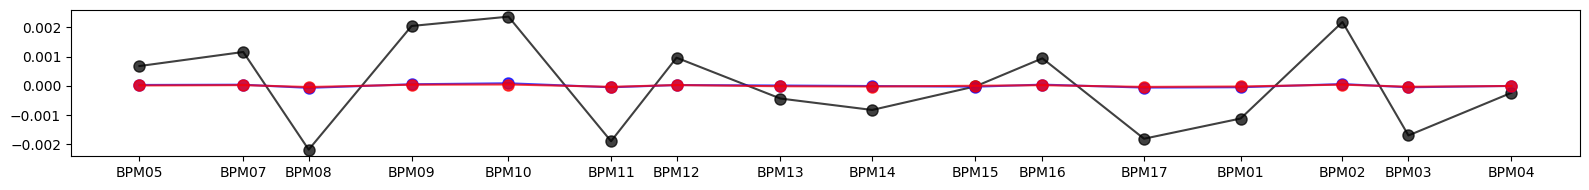

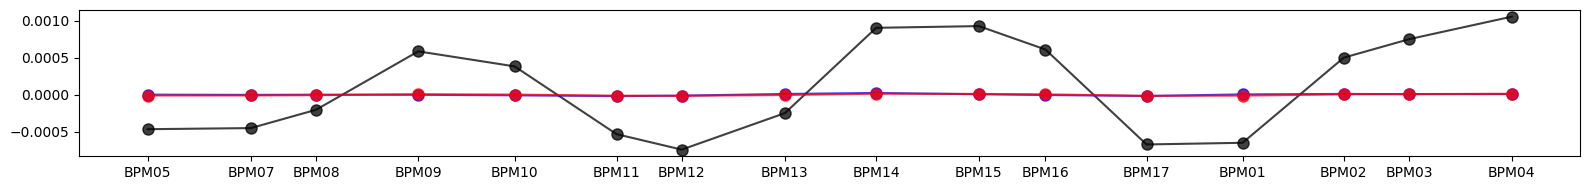

In [17]:
# Compare orbits after correction

# qx

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qx_initial.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx_model.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qx_error.cpu().numpy(), fmt='-', color='red', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()

# qy

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), qy_initial.cpu().numpy(), fmt='-', color='black', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy_model.cpu().numpy(), fmt='-', color='blue', marker='o', ms=8, alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), qy_error.cpu().numpy(), fmt='-', color='red', marker='o', ms=8, alpha=0.75)
plt.xticks(ticks=ring.locations(), labels=dict.fromkeys([name for name, kind, *_ in ring.layout() if kind == 'BPM']))
plt.tight_layout()
plt.show()